### Import & configure required packages

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

def format_float(x):
    return '{:.2f}'.format(x)

pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.float_format', format_float)
pd.set_option('display.max_rows', None)

### Load the 2022 US Survey of Consumer Finances STATA data

In [21]:
# Lood the data into a dataframe
df = pd.read_stata("../data/scf2022_extract.dta")

# Check that the data has been loaded correctly
expected_shape = (22975, 357)
assert df.shape == expected_shape, f"Expected shape {expected_shape}, but got {df.shape} - data not loaded correctly"

print("Dataframe loaded correctly")

# Capitalise all column names
df.columns = df.columns.str.upper()

# Remove weight column division by 5 from SAS macro
df["WGT"] = df["WGT"] * 5

Dataframe loaded correctly


### Target variable
Target variable is risk tolerance - a proxy variable derived from ratio of higher risk to lower risk investment total holdings

Proxy variables - higher risk investment total holdings:
* Stocks (STOCKS)
* Bonds (BOND)
* Non money market funds (NMMF)

Proxy variables - lower risk investment total holdings:
* Savings account (SAVING)
* Money market deposit account (MMDA)
* Money market funds (MMMF)
* Savings bonds (SAVBND)
* Certificate of deposit (CDS)


In [22]:
# Define the category of the proxy variables
higher_risk_columns = df[["STOCKS", "BOND", "NMMF"]]
lower_risk_columns= df[["SAVING", "MMDA", "MMMF", "SAVBND", "CDS"]]

# Calculate the sums of the proxy variables in each category
higher_risk_total_holdings = higher_risk_columns.sum(axis=1)
lower_risk_total_holdings = lower_risk_columns.sum(axis=1)

# Calculate total holdings - used for pre-processing and risk tolerance calculaiton
total_holdings = higher_risk_total_holdings + lower_risk_total_holdings

# Calculate risk tolerance
risk_tolerance = higher_risk_total_holdings / total_holdings

# Add new columns to dataframe
df = pd.concat([df, higher_risk_total_holdings.rename("HRTOTALHOLDINGS"), lower_risk_total_holdings.rename("LRTOTALHOLDINGS"), total_holdings.rename("TOTALHOLDINGS"), risk_tolerance.rename("RISKTOLERANCE")], axis=1)

### Preprocessing - cleaning the data

In [23]:
# Remove rows with missing values in the target variable
df = df.dropna(subset=["RISKTOLERANCE"])

### Weighted sampling - to ensure the data is representative of the population
Adv:
Dont have to worry about the weights when training the model
Nearly identical result to using the weighted dataset

Disadvantages:
Slower than using the weighted dataset
The results are probablistic.

In [24]:
# Distribution measures before sampling (unweighted)
unweighted_mean = df["RISKTOLERANCE"].mean()
unweighted_variance = df["RISKTOLERANCE"].var()
unweighted_skewness = df["RISKTOLERANCE"].skew()

print(f"(Unweighted) Mean: {unweighted_mean:.4f}, Variance: {unweighted_variance:.4f}, Skewness: {unweighted_skewness:.4f}")

# Distribution measures before sampling (weighted)
weighted_mean = (df["RISKTOLERANCE"] * df["WGT"]).sum() / df["WGT"].sum()
weighted_variance = (((df["RISKTOLERANCE"] - weighted_mean) ** 2) * df["WGT"]).sum() / df["WGT"].sum()
weighted_skewness = ((df["RISKTOLERANCE"] - weighted_mean) ** 3 * df["WGT"]).sum() / (df["WGT"].sum() * np.sqrt(weighted_variance) ** 3)

print(f"(Weighted) Mean: {weighted_mean:.4f}, Variance: {weighted_variance:.4f}, Skewness: {weighted_skewness:.4f}")

# The weights make the regression metrics innacurate so random sampling w/ weights is used to get a representative sample
df = df.sample(n=10000, replace=True, weights=df["WGT"], random_state=15)

# Distribution measures after sampling
sampled_mean = df["RISKTOLERANCE"].mean()
sampled_variance = df["RISKTOLERANCE"].var()
sampled_skewness = df["RISKTOLERANCE"].skew()

print(f"(Sampled) Mean: {sampled_mean:.4f}, Variance: {sampled_variance:.4f}, Skewness: {sampled_skewness:.4f}")

(Unweighted) Mean: 0.4003, Variance: 0.1882, Skewness: 0.3468
(Weighted) Mean: 0.2699, Variance: 0.1539, Skewness: 0.9880
(Sampled) Mean: 0.2735, Variance: 0.1547, Skewness: 0.9704


### Distribution of the target variable before preprocessing

0.27354723281709764
0   0.00
Name: RISKTOLERANCE, dtype: float64
0.0


Text(0.5, 1.0, 'Target Variable Distribution Before Filtering')

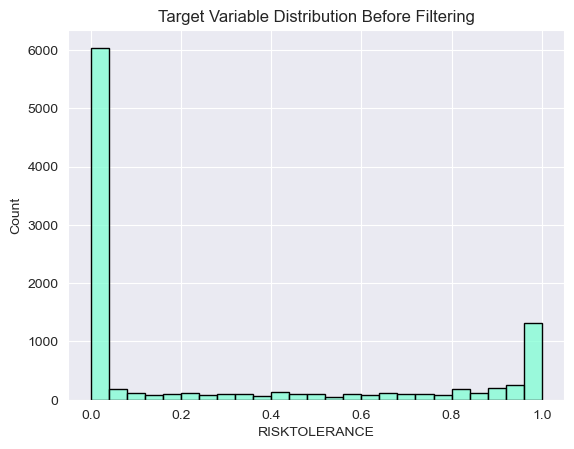

In [25]:
# Mean, mode and median of the risk tolerance variable
print(df["RISKTOLERANCE"].mean())
print(df["RISKTOLERANCE"].mode())
print(df["RISKTOLERANCE"].median())
# Plot the distribution of the risk tolerance variable
sns.histplot(df['RISKTOLERANCE'], kde=False, bins=25, color='aquamarine', edgecolor='black')
plt.title('Target Variable Distribution Before Filtering')

### Preprocessing - filtering for useful data

Remove investors without diversified portfolios
Remove rows with total holdings < 10000 

In [26]:
# Total holdings threshhold
print("Shape before total holdings filtering", df.shape)
df = df[df["TOTALHOLDINGS"] >= 10000]
print("Shape after total holdings filtering", df.shape)

# Diversification filtering
# Proportions of all asset class in the total holdings, addd small epsilon value to avoid division by zero
epsilon = 1e-9
df["STOCKS_PROP"] = df["STOCKS"] / df["TOTALHOLDINGS"] + epsilon
df["BOND_PROP"] = df["BOND"] / df["TOTALHOLDINGS"] + epsilon
df["NMMF_PROP"] = df["NMMF"] / df["TOTALHOLDINGS"] + epsilon
df["SAVING_PROP"] = df["SAVING"] / df["TOTALHOLDINGS"] + epsilon
df["MMDA_PROP"] = df["MMDA"] / df["TOTALHOLDINGS"] + epsilon
df["MMMF_PROP"] = df["MMMF"] / df["TOTALHOLDINGS"] + epsilon
df["SAVBND_PROP"] = df["SAVBND"] / df["TOTALHOLDINGS"] + epsilon
df["CDS_PROP"] = df["CDS"] / df["TOTALHOLDINGS"] + epsilon

# Entropy of the proportions
df["PROPENTROPY"] = -df[["STOCKS_PROP", "BOND_PROP", "NMMF_PROP", "SAVING_PROP", "MMDA_PROP", "MMMF_PROP", "SAVBND_PROP", "CDS_PROP"]].apply(lambda x: x * np.log(x)).sum(axis=1)

# Diversification score
num_classes = 8
df["DIVERSIFICATION"] = df["PROPENTROPY"] / np.log(num_classes)
print(df["DIVERSIFICATION"].mean())

# Filter for diversified investors
print("Shape before diversification filtering", df.shape)
df = df[df["DIVERSIFICATION"] > 0.25]
print("Shape after diversification filtering", df.shape)

Shape before total holdings filtering (10000, 361)
Shape after total holdings filtering (5855, 361)
0.1721814243553818
Shape before diversification filtering (5855, 371)
Shape after diversification filtering (2076, 371)


### Compute the most correlated variables with the risk tolerance variable

In [27]:
# Compute the most correlated variables with the risk tolerance variable
#correlation = df.corr()["RISKTOLERANCE"].sort_values(ascending=False)
#print(correlation)

### Distribution of the risk tolerance variable after preprocessing

0.44670371113910584
0   0.00
Name: RISKTOLERANCE, dtype: float64
0.4425613294645212


Text(0.5, 1.0, 'Target Variable Distribution After Filtering')

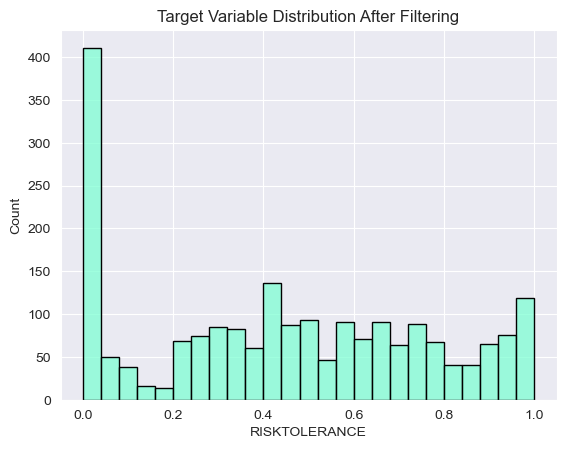

In [28]:
# Mean, mode and median of the risk tolerance variable
print(df["RISKTOLERANCE"].mean())
print(df["RISKTOLERANCE"].mode())
print(df["RISKTOLERANCE"].median())
# Plot the distribution of the risk tolerance variable
sns.histplot(df['RISKTOLERANCE'], kde=False, bins=25, color='aquamarine', edgecolor='black')
plt.title('Target Variable Distribution After Filtering')

### Correlation of features selected in original case study

Text(0.5, 0.98, 'Correlation Matrix of Case Study Features, 2022 SCF Dataset')

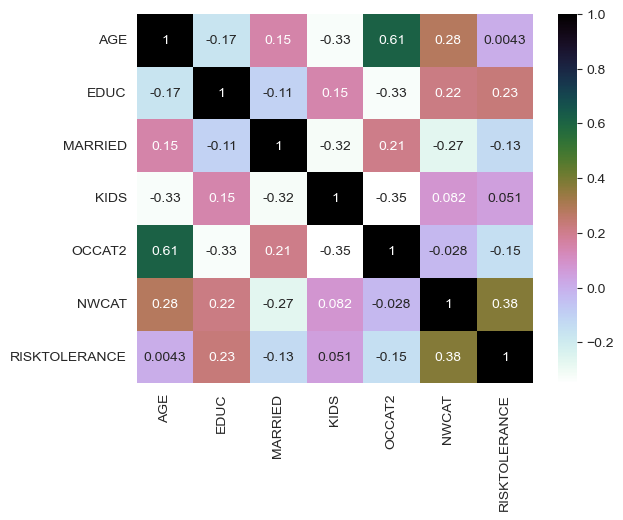

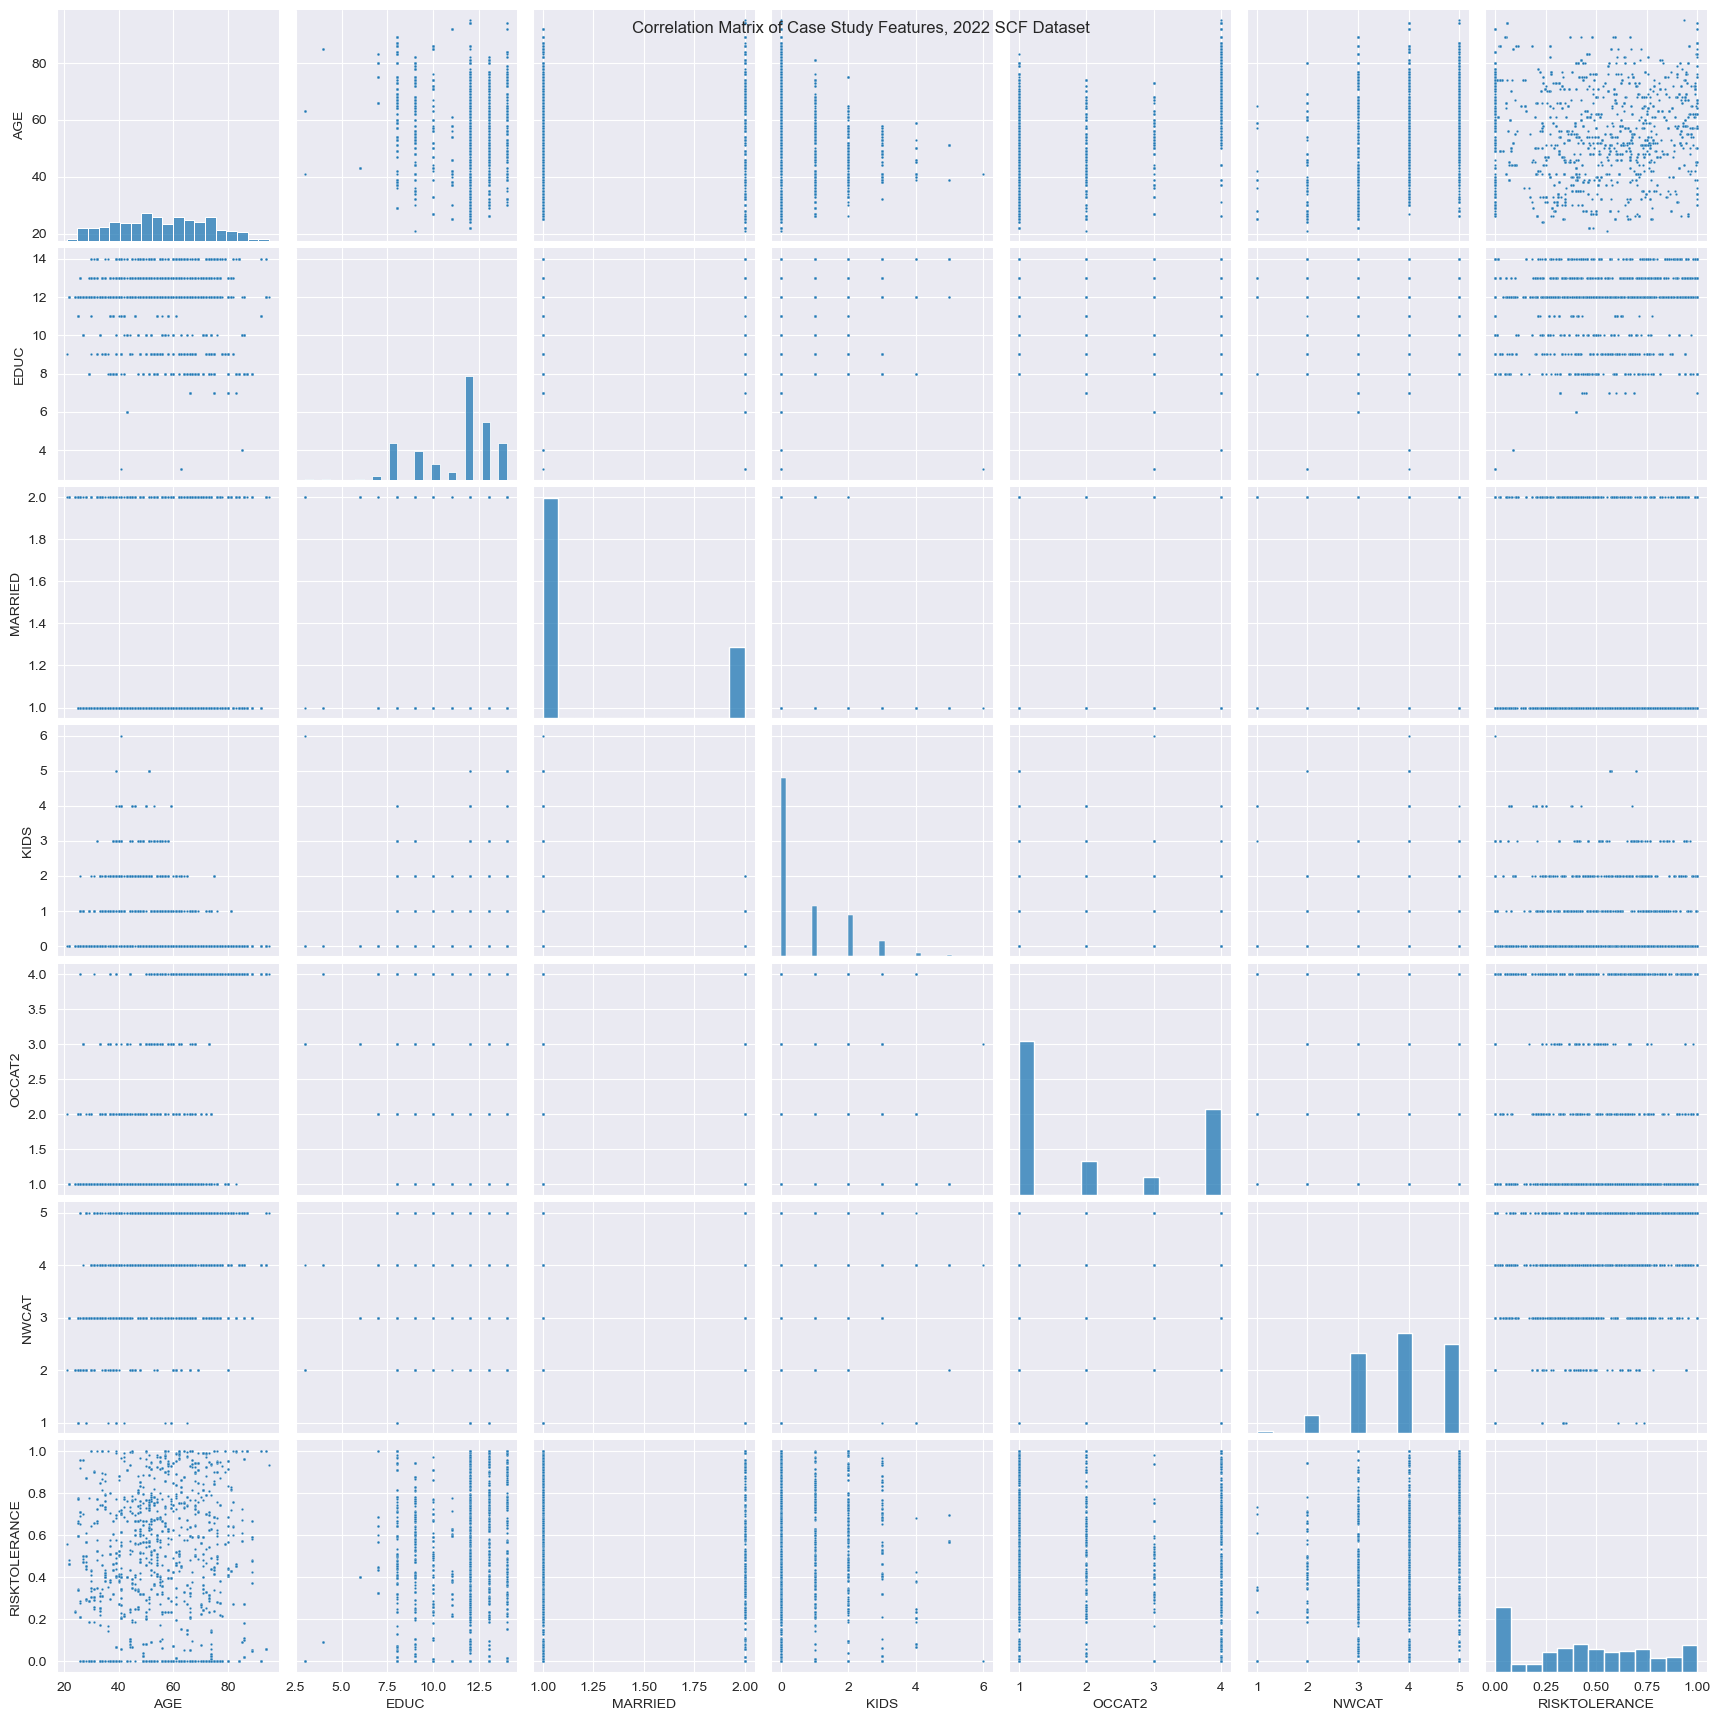

In [29]:
test_cs_columns = ["AGE", "EDUC", "MARRIED", "KIDS", "OCCAT2", "INCCL2",  "NWCAT", "RISKTOLERANCE"]

df_test_cs = df.drop(df.columns.difference(test_cs_columns), axis=1)

# Correlation matrix
original_cmap = sns.color_palette("cubehelix", as_cmap=True)
reversed_cmap = original_cmap.reversed()

sns.heatmap(df_test_cs.corr(), vmax=1, annot=True, cmap=reversed_cmap)

# Scatterplot matrix
sns.pairplot(df_test_cs, plot_kws={'s': 3})
plt.suptitle('Correlation Matrix of Case Study Features, 2022 SCF Dataset')

### Feature Selection
* Married? (MARRIED) - 1=Married/living with partner, 2= not,
* No. of children (KIDS)
* Occupation category 2 (OCCAT2) - occupation classification for reference person:
    1=managerial/professional 2=technical/sales/services,
    3=other (incl. production/craft/repair workers, operators,
    laborers, farmers, foresters, fishers) 4=not working;
* Income (INCOME):
* Net worth (NETWORTH):
* Value of primary residence (HOUSES):
* Education (EDUC): 1=no high school diploma/GED, 2=high school diploma or GED,
    3=some college or Assoc. degree, 4=Bachelors degree or higher;
* Financial literacy (FINLIT) - number of correct answers to 3 financial literacy questions


In [30]:
# Select the features for the model
feature_columns = ["MARRIED", "KIDS", "OCCAT2", "INCOME", "NETWORTH", "HOUSES", "EDUC", "FINLIT"]

# Add the target variable to the list of columns
all_columns = feature_columns + ["RISKTOLERANCE"]

# Drop the other columns from the dataset
df = df.drop(df.columns.difference(all_columns), axis=1)

# Reorder the columns to match the order of the all_columns list
df = df[all_columns]

### Correlation of the selected features

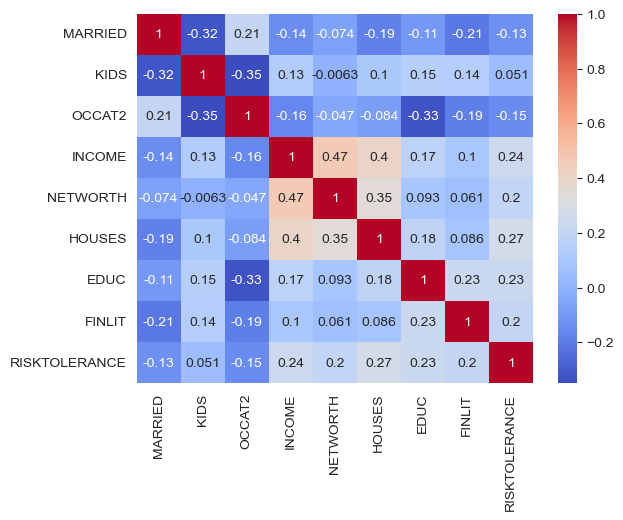

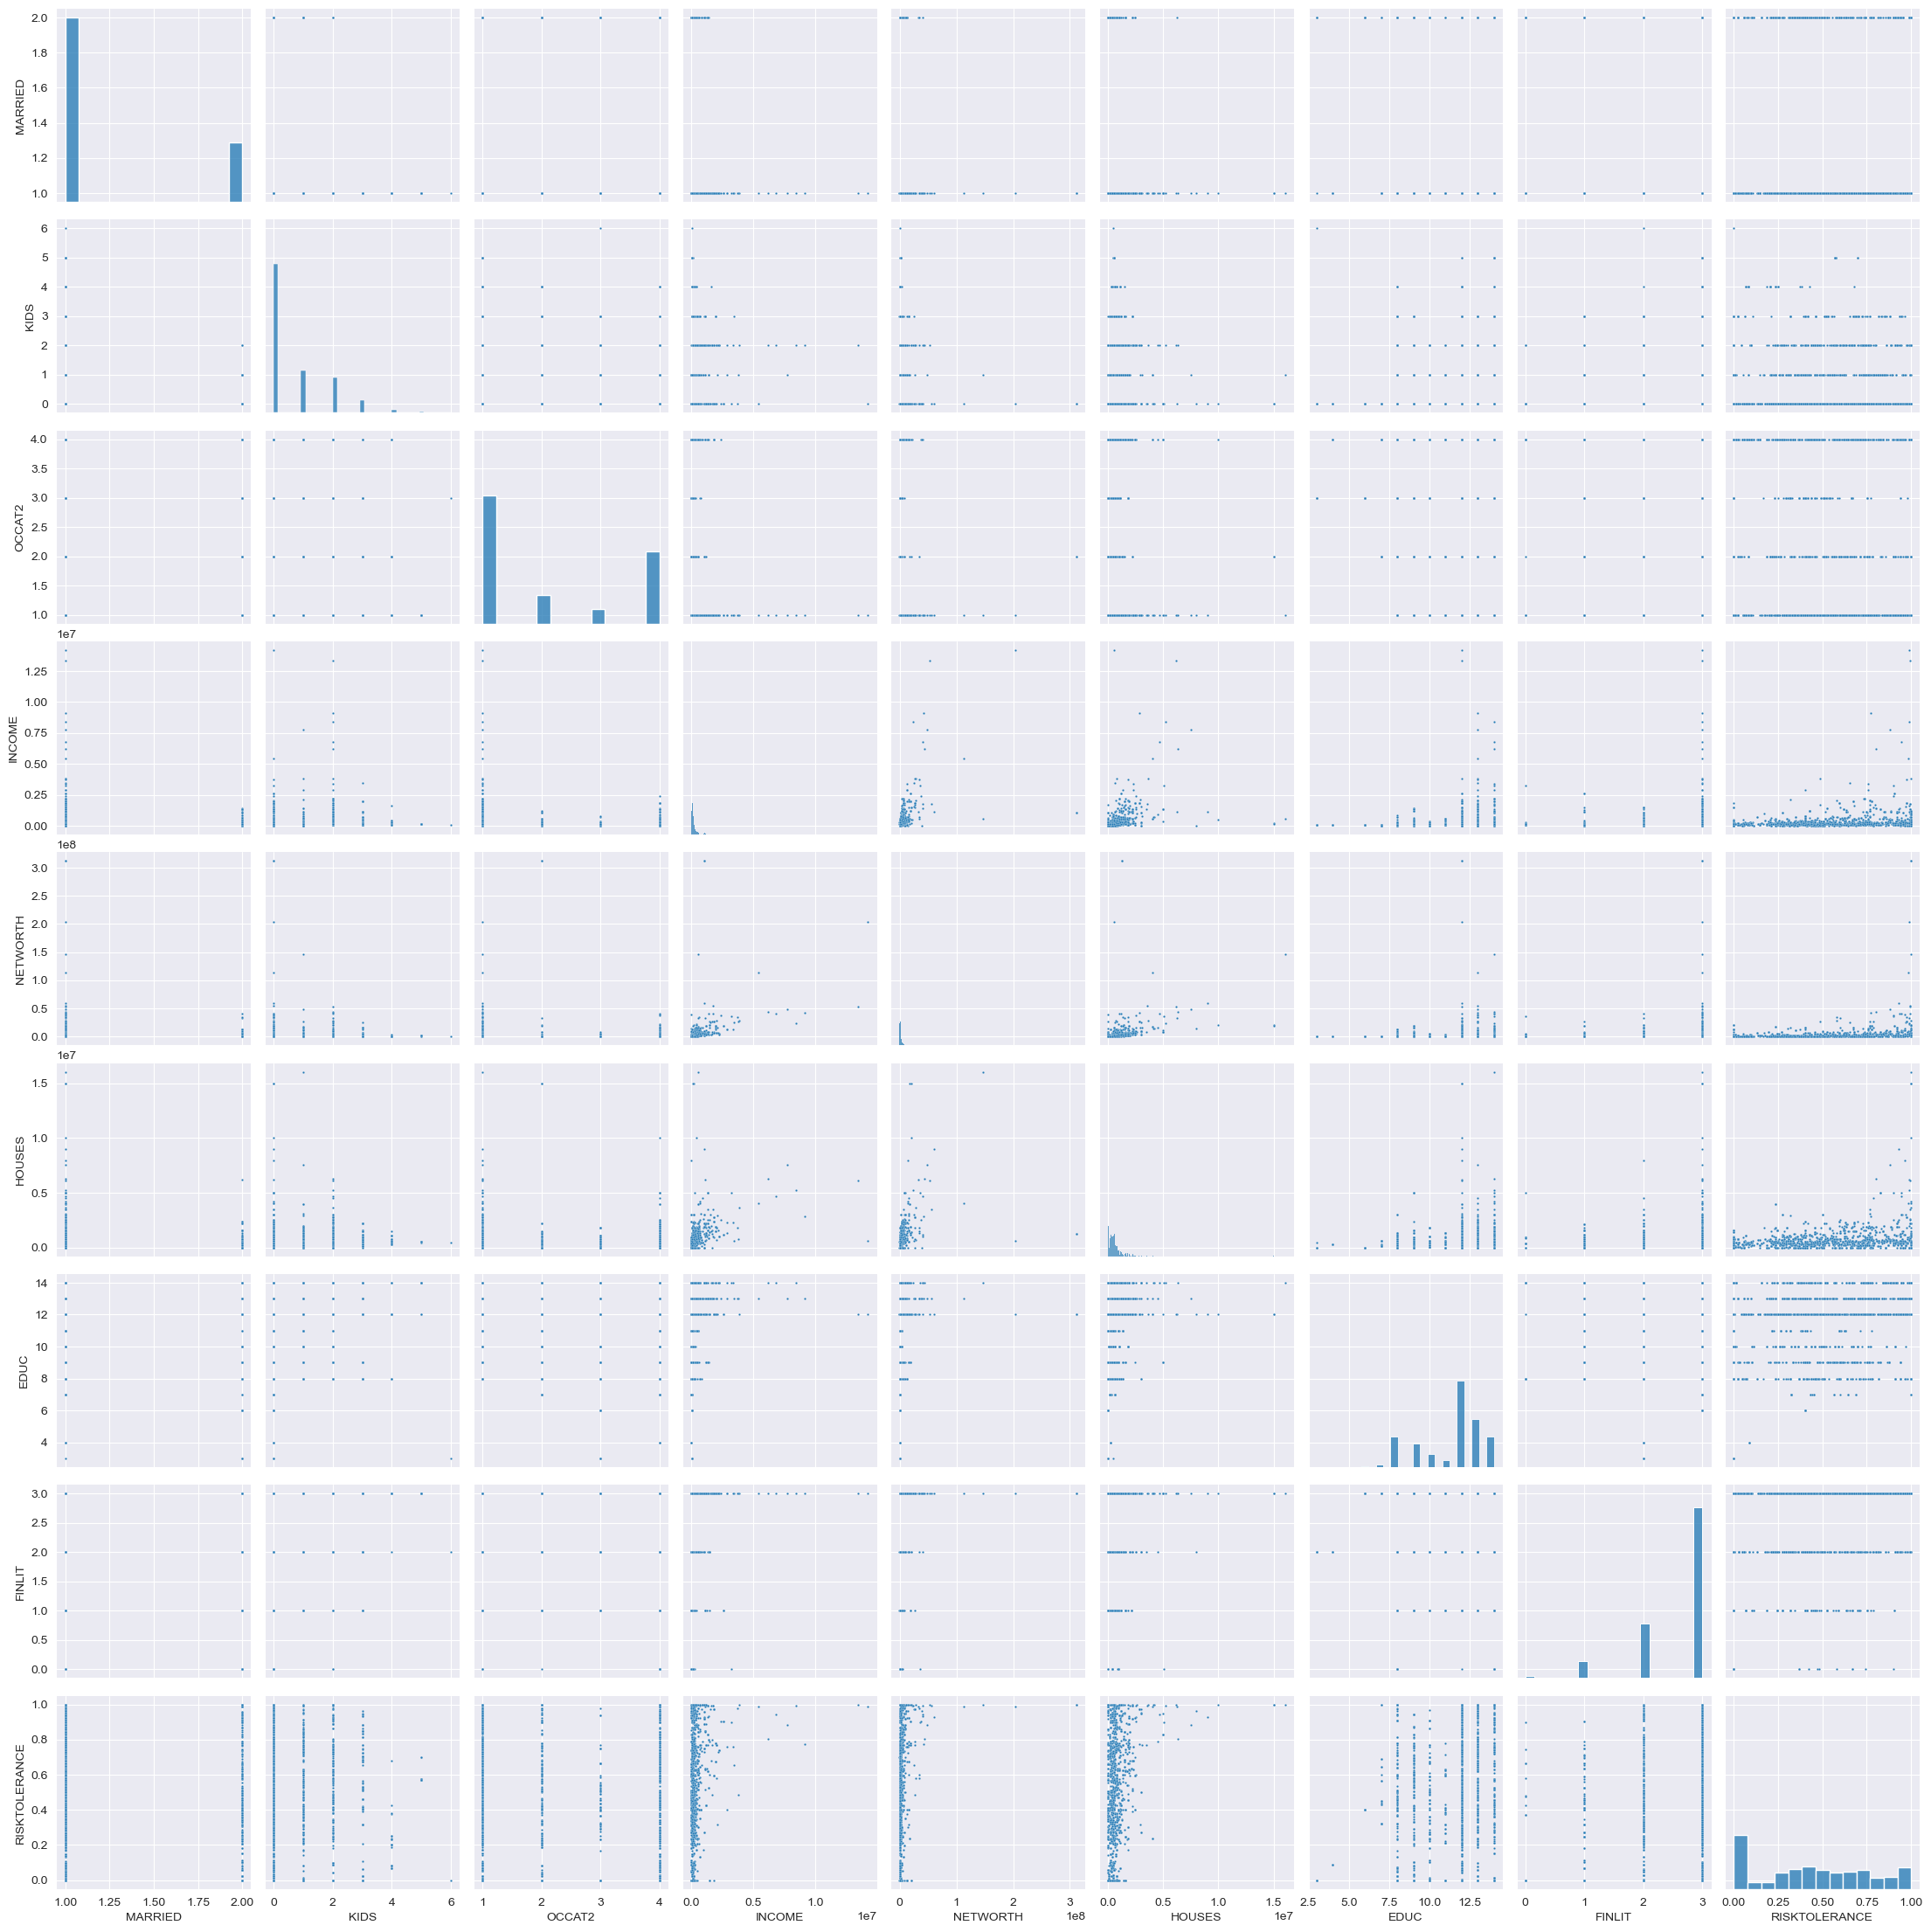

In [31]:
# Correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Scatterplot matrix
sns.pairplot(df, plot_kws={'s': 3})

### Training options

In [32]:
fixed_seed = 15
num_folds = 10

### Splitting data into training and testing sets
Training set: 70%
Validation set: 15%
Testing set: 15%

In [33]:
x = df.drop("RISKTOLERANCE", axis=1)
y = df["RISKTOLERANCE"]

# Standardisation
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=fixed_seed)

### Defining sklearn models for model determination

In [34]:
models = []

# Linear models
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet())) # Combines Lasso and Ridge
# Ensemble models - boosting
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Ensemble models - bagging
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
# Other models
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor())) # Classification and Regression Trees
models.append(('SVR', SVR())) # Support Vector Machine (SVM)

### Evaluate models

In [35]:
import time

# Start timer
start = time.time()

# Evaluate each model w/ k-fold cross validation (set to 5) using neg RMSE, neg MSE, neg MAE and r2 as metrics
evaluation_metrics = ['neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=fixed_seed)

# Evaluate each model
results = []
for model_name, model in models:
    # Add the metrics dictionary to the results for this model
    results.append({'model_name': model_name, 'metrics': {metric: [] for metric in evaluation_metrics}})
    # Evaluate the model using each metric
    for metric in evaluation_metrics:
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=metric)
        results[-1]['metrics'][metric].append(cv_results)
        print(f"Model: {model_name}, Metric: {metric}, Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.3f}")
    print("\n")
    
# End timer
end = time.time()
print(f"Time taken: {end - start:.4f} seconds")

Model: LR, Metric: neg_root_mean_squared_error, Mean: -0.3000, Std: 0.009
Model: LR, Metric: neg_mean_squared_error, Mean: -0.0901, Std: 0.005
Model: LR, Metric: neg_mean_absolute_error, Mean: -0.2551, Std: 0.009
Model: LR, Metric: r2, Mean: 0.1179, Std: 0.028


Model: LASSO, Metric: neg_root_mean_squared_error, Mean: -0.3207, Std: 0.008
Model: LASSO, Metric: neg_mean_squared_error, Mean: -0.1029, Std: 0.005
Model: LASSO, Metric: neg_mean_absolute_error, Mean: -0.2733, Std: 0.010
Model: LASSO, Metric: r2, Mean: -0.0077, Std: 0.012


Model: RIDGE, Metric: neg_root_mean_squared_error, Mean: -0.3000, Std: 0.009
Model: RIDGE, Metric: neg_mean_squared_error, Mean: -0.0901, Std: 0.005
Model: RIDGE, Metric: neg_mean_absolute_error, Mean: -0.2551, Std: 0.009
Model: RIDGE, Metric: r2, Mean: 0.1180, Std: 0.028


Model: EN, Metric: neg_root_mean_squared_error, Mean: -0.3207, Std: 0.008
Model: EN, Metric: neg_mean_squared_error, Mean: -0.1029, Std: 0.005
Model: EN, Metric: neg_mean_absolute_error,

### Compare models w/ boxplot for each metric

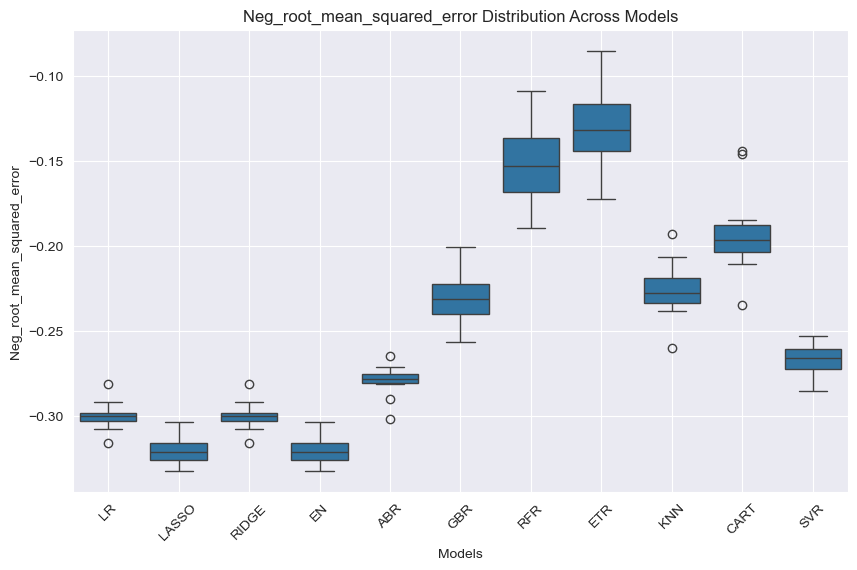

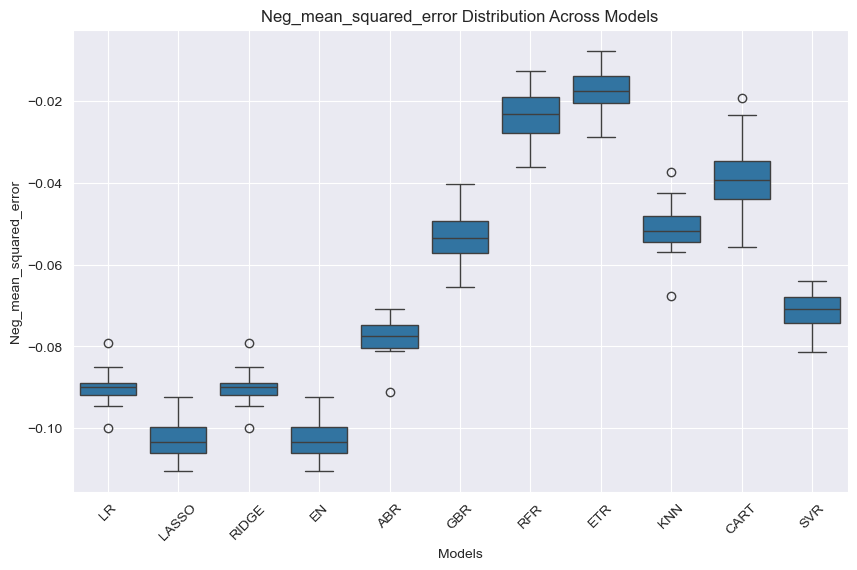

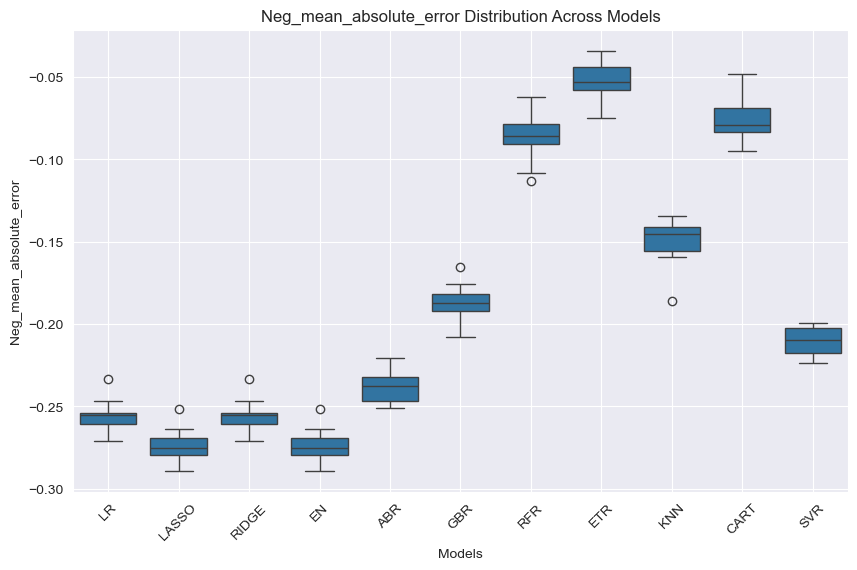

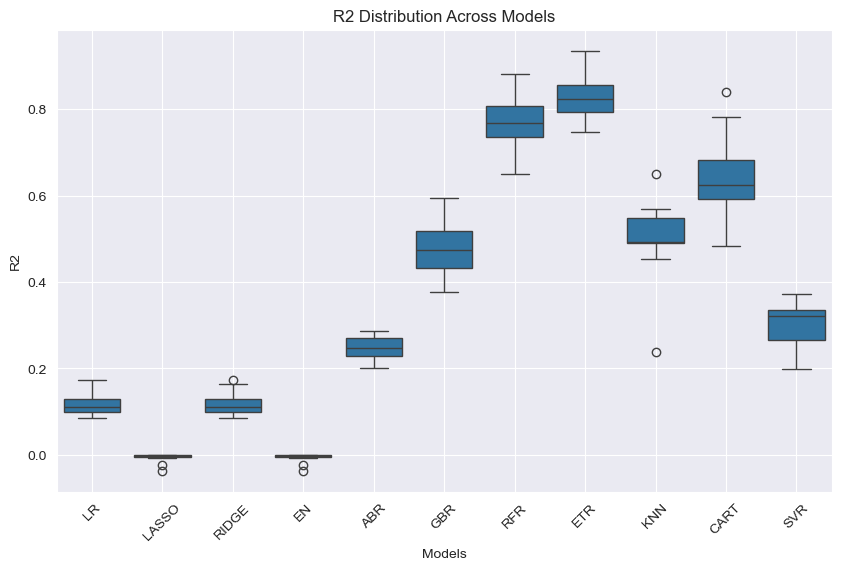

In [36]:
for metric in evaluation_metrics:
    metric_data = []
    model_names = []
    for model in results:
        metric_data.extend(model['metrics'][metric][0])
        model_names.extend([model['model_name']] * len(model['metrics'][metric][0]))
 
    df = pd.DataFrame({'Model': model_names, metric.capitalize(): metric_data})
    
    # Plot boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y=metric.capitalize(), data=df)
    plt.title(f'{metric.capitalize()} Distribution Across Models')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Hyperparameter tuning
Extra trees regression model (ETR) has the best performance based on the evaluation metrics so will continue with it, attempting to improve it further with hyperparameter tuning. 

Grid search was prohibitively slow, so will use random search instead. Strategy- course search first for speed then fine search to ensure best hyperparameters are found.

In [62]:
model = ExtraTreesRegressor()

param_grid = {
    'n_estimators': [160, 165, 170, 175, 180, 185, 190, 195, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [60, 65, 70, 75, 80, 85, 90, 95, 100],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring='r2', cv=kfold, n_jobs=4)
random_result = random_search.fit(x_train, y_train)

print(f"Best: {random_result.best_score_} using {random_result.best_params_}")

Best: 0.8348882869485225 using {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70}


### Train the model with the best hyperparameters

In [63]:
etr = ExtraTreesRegressor(**random_result.best_params_)
etr.fit(x_train, y_train)

# Use cross validation to evaluate the model after hyperparameter tuning
for metric in evaluation_metrics:
    cv_results = cross_val_score(etr, x_train, y_train, cv=kfold, scoring=metric)
    print(f"Metric: {metric}, Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}")


Metric: neg_root_mean_squared_error, Mean: -0.1282, Std: 0.0261
Metric: neg_mean_squared_error, Mean: -0.0172, Std: 0.0068
Metric: neg_mean_absolute_error, Mean: -0.0524, Std: 0.0128
Metric: r2, Mean: 0.8359, Std: 0.0598


### Feature importances

Text(0.5, 0, 'Feature')

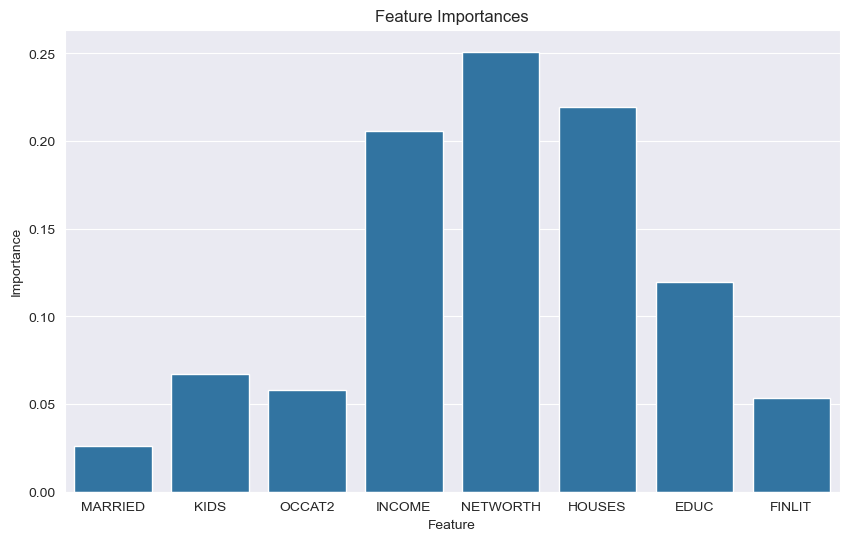

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_columns, y=etr.feature_importances_)
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')

### Model now finalised, use evaluation metrics on the test set to see how well the model generalises to unseen data

In [40]:
y_test_pred = etr.predict(x_test)

# Metrics on test set
r2_test = r2_score(y_test, y_test_pred)
mse_test = sum((y_test - y_test_pred) ** 2) / len(y_test)
rmse_test = mse_test ** 0.5
mae_test = sum(abs(y_test - y_test_pred)) / len(y_test)

# Print the metrics
print(f"test set metrics:")
print(f"R2: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")

test set metrics:
R2: 0.8395
MSE: 0.0163
RMSE: 0.1277
MAE: 0.0519


### Dump the model for use by the ML API

In [41]:
from joblib import dump
dump(etr, '../models/final_model.joblib')

['../models/final_model.joblib']

### Dump the scaler for use by the ML API

In [42]:
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']